In [1]:
!pip install albumentations
!pip install torchmetrics
!pip install paddleocr>=2.0.1 paddlepaddle
!pip install opencv-python-headless==4.5.3.56
!pip install segmentation_models_pytorch

In [188]:
%%time
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT
import warnings
warnings.filterwarnings("ignore")
# from pipeline import segmentation
# from pipeline import correct_perspective
# from pipeline import text_detection
from pipeline.rules import ru, find_nearby
from pipeline import OCR
from pipeline import classifier
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.96 ms


In [189]:
%%time
## EVALUATION ON EACH IMAGE
img_classes = [ 'BPL-EliteView-EV10-B_Meditec-England-A', 'BPL-EliteView-EV100-C' , 'BPL-Ultima-PrimeD-A' , 'Nihon-Kohden-lifescope-A']
TEST_IMG_DIR = f"val/{img_classes[0]}"

imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[5]}"

image = cv2.cvtColor(cv2.imread(imloc), cv2.COLOR_BGR2RGB)
ocr_io = cv2.resize(image, (320, 180))
class_io = cv2.resize(image, (640, 360))


# mask = segmentation.maskPred(image)
# # print(mask)
# (ocr_io, class_io, orig_io) =  correct_perspective.correctPerspective(image, mask)
label = classifier.classification(class_io) 

#label = 2
if label==1:
    candidates =  OCR.get_text(class_io, det=True)
    ocr_io = class_io
elif label == 3:
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    ocr_io = cv2.filter2D(ocr_io, -1, kernel)
    
    candidates =  OCR.get_text(ocr_io[:, :115], det=True)
else:
    print("here")
    candidates =  OCR.get_text(ocr_io, det=True)
can = candidates[0]
# plt.imshow(ocr_io[:, :115])
# plt.show()

result = {}
hr_boxes = []

boxes = []
yellow_boxes = []
slash_box = []
for line in can:
    bbox = line[0]
    txt = line[1][0]
    confidence = line[1][1]
    
    x1, y1, x2, y2 = int(bbox[0][0]),int(bbox[0][1]) , int(bbox[2][0]),int(bbox[2][1])
    cropped = ocr_io[y1: y2, x1:x2]
    # print(x1, y1,x2,y2)
    # print(txt)
    # plt.imshow(cropped)
    # plt.show()
    pred = ru.class_pred(txt, cropped, label)
    if len(re.findall("^/\d+", txt.strip()))>0:
        slash_box = [(x1+x2)/2, (y1+y2)/2, x2-x1,y2-y1, txt]
    else:
        boxes.append([(x1+x2)/2, (y1+y2)/2, x2-x1,y2-y1, txt ])
    if len(pred)>0:
        clas = pred[0]
        if(clas=="BP"):
            result[pred[1][0][0]] = pred[1][0][1]
            result[pred[1][1][0]] = pred[1][1][1]
        elif(clas == 'HR'):
            hr_boxes.append([cropped.shape[0]*cropped.shape[1], [x1,y1,x2,y2], pred])
        elif(clas == 'cyan'):
            if label == 1:
                result['RR'] = pred[1]
            elif label==0 or label == 2: 
                result['SPO2'] = pred[1]
        elif(clas=='yellow'):
            if label == 1:
                yellow_boxes.append([(y1+y2)/2, cropped.shape[0]*cropped.shape[1], [x1,y1,x2,y2], txt])
            elif label == 0 or label == 2:
                result['RR'] = txt
            elif label == 3:
                result['SPO2'] = txt
                
#         print(txt ,"-", len(pred))
yellow_boxes = sorted(yellow_boxes, key=lambda x: x[0], reverse=True)
hr_boxes = sorted(hr_boxes, key=lambda x: x[0], reverse=True)

if label == 1 and len(yellow_boxes) > 0:
    result['SPO2'] = yellow_boxes[0][3]

if len(hr_boxes)>0:
    x1,y1,x2,y2 = hr_boxes[0][1]
    hr = (hr_boxes[0][2][1][0])
    a = re.findall('^\d+', hr)
    hr = int(a[0])
    if int(a[0][:3]) > 220:
        hr = int(a[0][:2])
    elif int(a[0]) > 300:
        hr = int(a[0][:3])
    result['HR'] = hr
#         plt.imshow(ocr_io[y1: y2, x1:x2])
#         plt.show()

if len(slash_box) > 0:
    index = find_nearby(slash_box, boxes)
    x, y, w, h, pred = boxes[index]
    
    result['SBP'] = pred.strip()
    result['DBP'] = slash_box[-1][1:]

boxes = sorted(boxes, key= lambda x: x[1], reverse=True)
if label == 3:
    for (x,y,w,h,pred) in boxes:
        if w*h > 200:
            if pred[1] == 'T':
                pred = pred[0] + '7'
            result['RR'] = pred
            break



print(result)

here
[2023/02/06 00:28:32] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/02/06 00:28:32] ppocr DEBUG: dt_boxes num : 12, elapse : 0.05675673484802246
[2023/02/06 00:28:33] ppocr DEBUG: rec_res num  : 12, elapse : 0.6692333221435547
{'SBP': '115', 'DBP': '70', 'SPO2': '95', 'RR': '17', 'HR': 87}
CPU times: user 1.71 s, sys: 0 ns, total: 1.71 s
Wall time: 854 ms


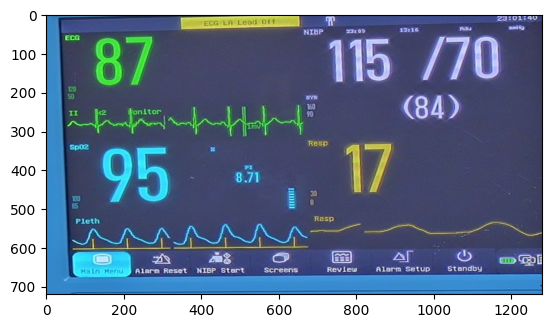

In [185]:
plt.imshow(image)

In [178]:
print(label)

2


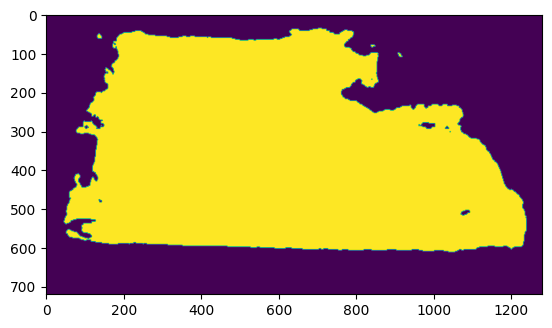

In [66]:
plt.imshow(mask)

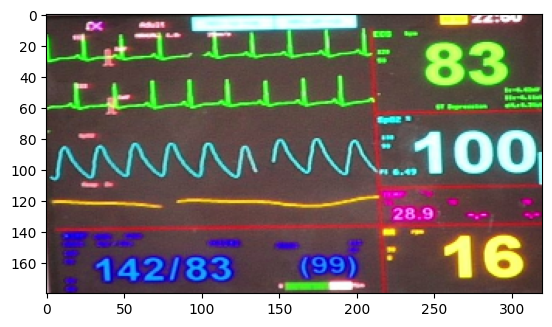

In [180]:
plt.imshow(ocr_io)

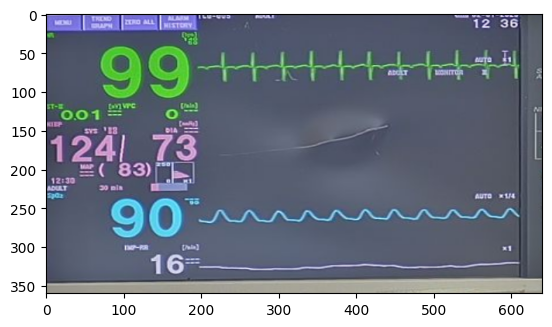

In [6]:
plt.imshow(class_io)

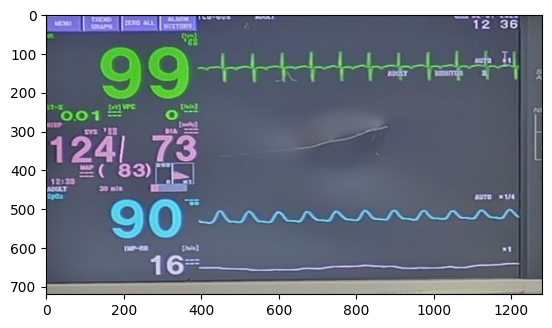

In [7]:
plt.imshow(orig_io)